## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [16]:
import os
import keras
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [17]:
train, test = keras.datasets.cifar10.load_data()

In [18]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [19]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [20]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [21]:
"""Code Here
設定超參數
"""

LEARNING_RATE = 1e-3
EPOCHS = 5
BATCH_SIZE = 1024
MOMENTUM = 0.95
MONITOR=['val_accuracy','val_loss']
PATIENCE=[10,25]

In [22]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""

from keras.callbacks import EarlyStopping

import keras.backend as K

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""



results = {}
for i, (patience, monitor) in enumerate(itertools.product(PATIENCE, MONITOR)):
    K.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    earlystop = EarlyStopping(monitor=monitor, 
                              patience=patience, 
                              verbose=1
                              )

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )
    
    # Collect results
    #exp_name_tag = ("exp-%s" % (i))
    exp_name_tag = "exp-patience-%s-monitor-%s" % (str(patience), str(monitor))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

Epoch 2/5
50000/50000 [==============================] - 4s 89us/step - loss: 1.7478 - accuracy: 0.3913 - val_loss: 1.9884 - val_accuracy: 0.2796
Epoch 3/5
50000/50000 [==============================] - 4s 88us/step - loss: 1.6233 - accuracy: 0.4320 - val_loss: 1.8408 - val_accuracy: 0.3589
Epoch 4/5
50000/50000 [==============================] - 4s 88us/step - loss: 1.5496 - accuracy: 0.4565 - val_loss: 1.7325 - val_accuracy: 0.4003
Epoch 5/5
50000/50000 [==============================] - 5s 101us/step - loss: 1.4933 - accuracy: 0.4759 - val_loss: 1.6551 - val_accuracy: 0.4253


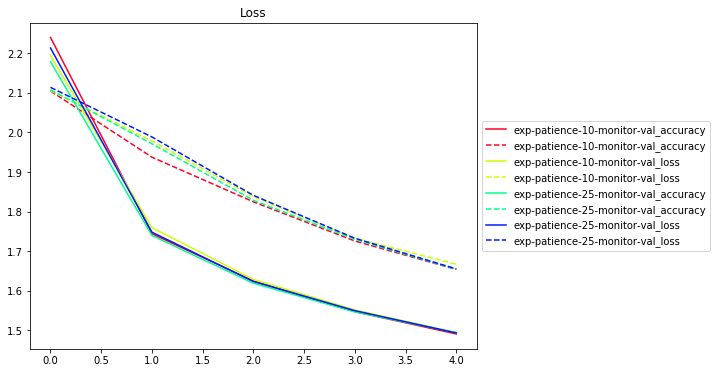

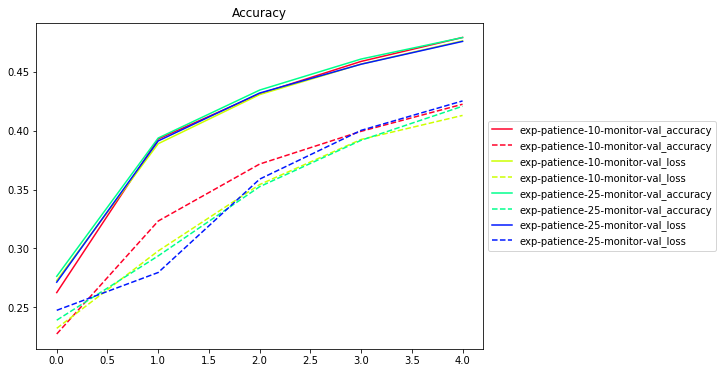

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()